#  Masking Pipeline

In [ ]:
from chxanalys.chx_libs import np, roi, time, datetime, os,  getpass, db, get_images,LogNorm, plt,ManualMask

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,load_data, 
                                             RemoveHot, show_img, get_avg_img, reverse_updown)
 
%matplotlib notebook

# Path for Saving Results

In [3]:
path = '/XF11ID/analysis/2016_3/masks/'
print ("The analysis results will be saved in : %s"%path)



The analysis results will be saved in : /XF11ID/analysis/2016_3/masks/


### Get the image series and metadata from the uid

In [4]:
uid = '05e27b' #count : 1 ['05e27b'] (scan num: 2968) (Measurement: CoralPor 1kHz 5k frames )

uid = 'eaed19'  #count : 1 ['eaed19'] (scan num: 3929) (Measurement: coralpor 750Hz 5k )  

In [5]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  3929--eaed19aa-8c10-465b-b2de-32b23596609a--/XF11ID/data/2016/10/28/c81bda03-c2f9-4f60-908b_134


In [6]:
#imgs = load_data( uid, detector, reverse= True  )
imgs = load_data( uid, detector, reverse= False  )
md = imgs.md

hdf5 path = /XF11ID/data/2016/10/28/c81bda03-c2f9-4f60-908b_134_master.h5


In [7]:
imgs

<Frames>
Length: 5000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [8]:
Nimg=len(imgs)

In [57]:
md

{'beam_center_x': 1475.0,
 'beam_center_y': 786.0,
 'count_time': 0.00134,
 'detector_distance': 4890.0,
 'frame_time': 0.00135,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [55]:
#%matplotlib inline

In [9]:
 md['pixel_mask'] =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

In [56]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

## show image and the pixel mask

<IPython.core.display.Javascript object>


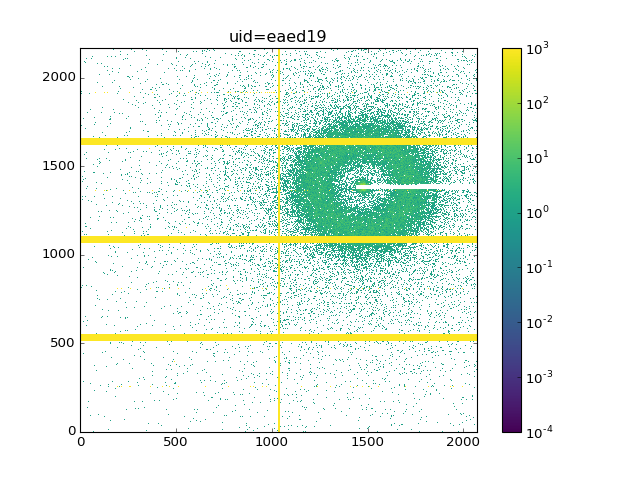

In [12]:
show_img(  imgs[0] , vmin=.0001, vmax=1000, logs=True, image_name ='uid=%s'%uid )

<IPython.core.display.Javascript object>


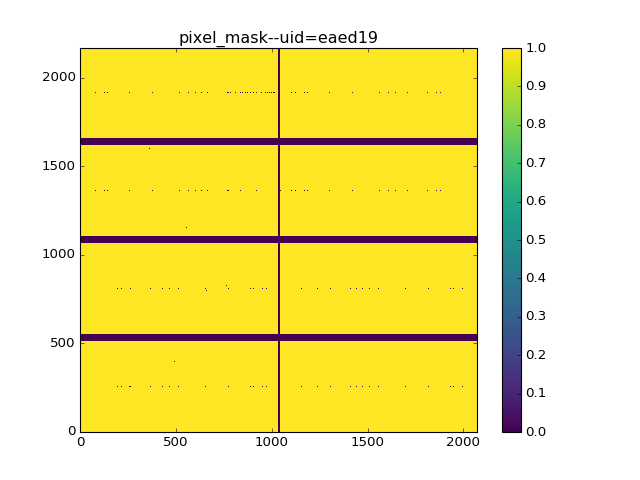

In [13]:
show_img(md['pixel_mask'], vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid )

## Remove hotspots in the image

In [14]:
imgs.shape

(2167, 2070)

In [15]:
2167 - 799

1368

<IPython.core.display.Javascript object>


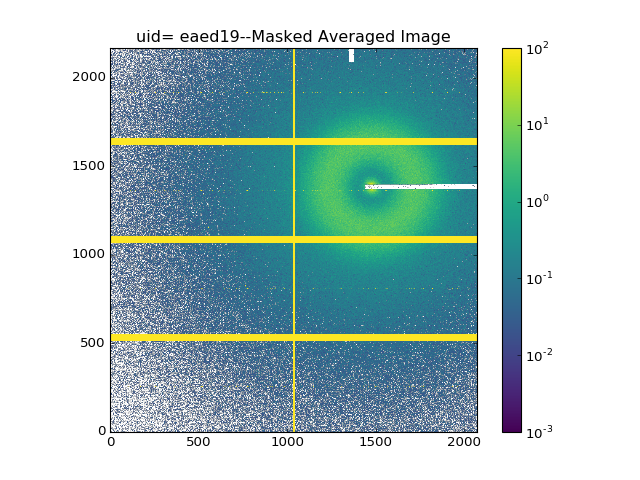

In [16]:
avg_img =  get_avg_img( imgs, sampling = 1000, plot_ = True, uid =uid)

<IPython.core.display.Javascript object>


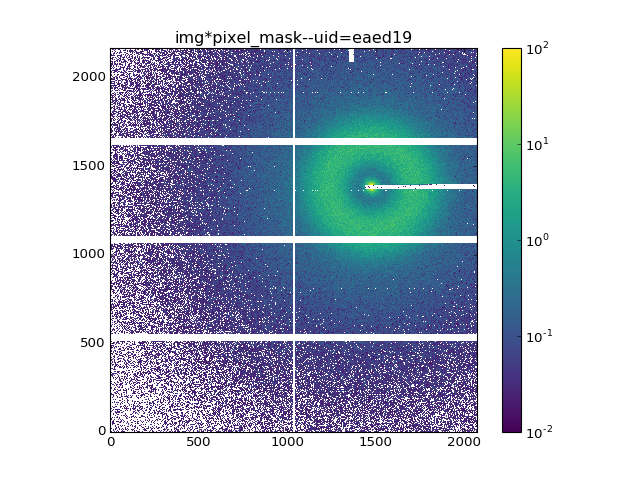

In [18]:
show_img(  avg_img*md['pixel_mask'],   vmin= .01, vmax= 100,
         logs= True, aspect=1.,image_name ='img*pixel_mask--uid=%s'%uid )

In [19]:
avg_img.shape

(2167, 2070)

<IPython.core.display.Javascript object>


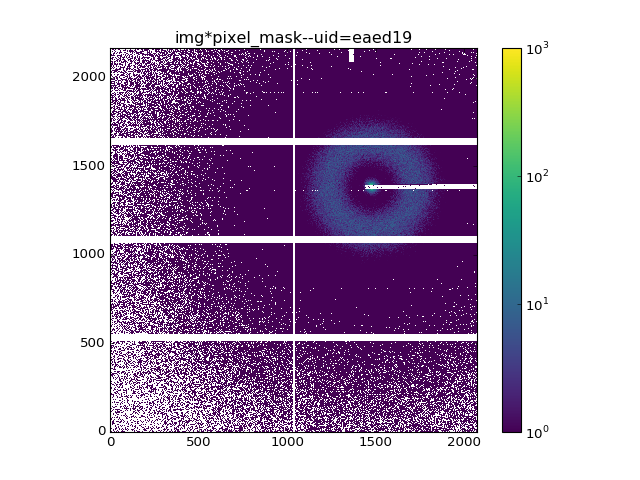

In [20]:
show_img(  avg_img*md['pixel_mask'],   vmin= 1, vmax= 1000,  aspect=1.,
         
         logs= True, image_name ='img*pixel_mask--uid=%s'%uid )

<IPython.core.display.Javascript object>


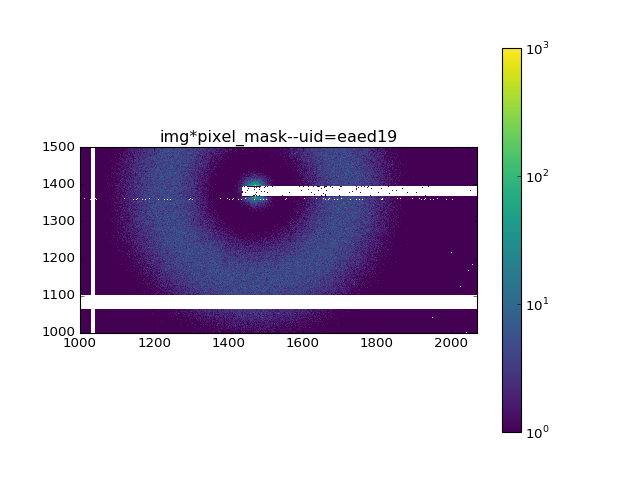

In [21]:
show_img(  avg_img*md['pixel_mask'],   vmin= 1, vmax= 1000, xlim=[1000, 2070], ylim=[1000, 1500], aspect=1.,
         
         logs= True, image_name ='img*pixel_mask--uid=%s'%uid )

In [27]:
avg_img.shape

(2167, 2070)

In [33]:
2167-784

1383

<IPython.core.display.Javascript object>


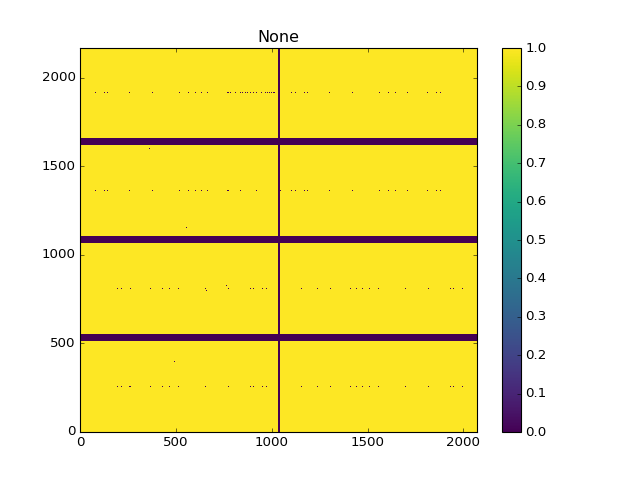

In [22]:
mask_rh  = RemoveHot( avg_img, 5E4, plot_=True)

## Manually create the mask file

<IPython.core.display.Javascript object>


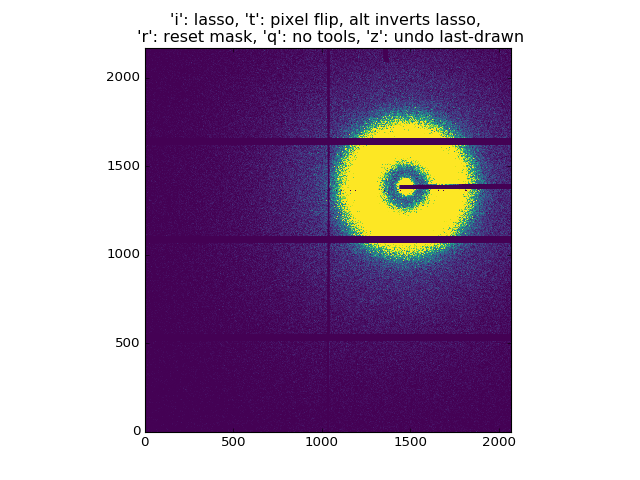

In [23]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img* md['pixel_mask']*mask_rh,
               cmap='viridis',origin='lower',
               vmin=.01, vmax=1.50) 
plt.show()

<IPython.core.display.Javascript object>


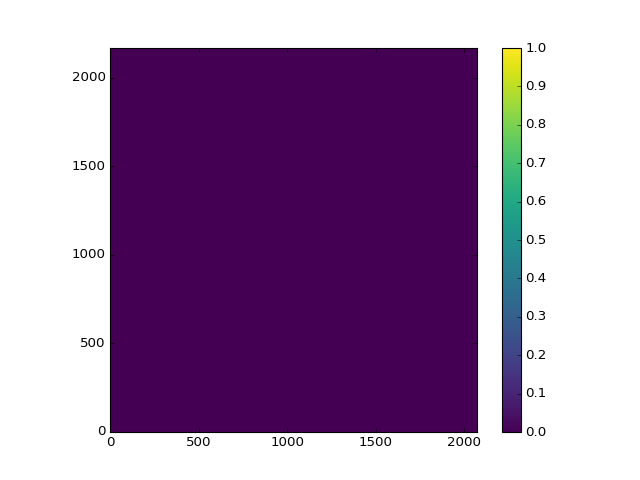

In [24]:
new_mask = m.mask
manu_mask  = new_mask.copy()
fig, ax = plt.subplots()
im=ax.imshow(new_mask,origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

In [25]:
manu_mask  = new_mask.copy()

# Create a polygon mask

In [26]:
from skimage.draw import line_aa, line, polygon

In [27]:
imgs.shape

(2167, 2070)

### To create multi-rectangle masks, for each sub-mask,
* Make x= the coordinate-x of the four cornners (pay attention to the reserve image-xy to python-xy )
* Make y= the coordinate-y of the four cornners 

In [43]:
#center of beam stop
bst_mask = np.zeros_like( avg_img , dtype = bool)

##h
cx= 1750
cy = 1380
wx= 2070- cx
wy = 20

x = np.array( [ cx-wx, cx+wx, cx+wx, cx - wx,  ])  
y = np.array( [ cy-wy, cy-wy, cy + wy, cy + wy])
rr, cc = polygon( y,x)
bst_mask[rr,cc] =1


#c=1381
#w=5
#bst_mask2 = np.zeros_like( avg_img , dtype = bool)
#x = np.array( [ 0,    1340,   1340,     0])
#y = np.array( [ c-w, c-w,  c+w,    c+w])
#rr, cc = polygon( y,x)
#bst_mask2[rr,cc] =1



full_mask= ~bst_mask #* ~bst_mask2 *~bst_mask3 *~bst_mask4




<IPython.core.display.Javascript object>


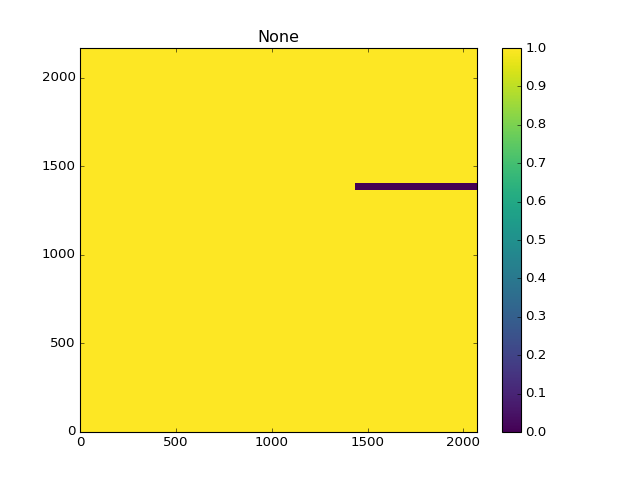

In [44]:
show_img(full_mask)

In [46]:
mask = np.array ( full_mask * md['pixel_mask']*mask_rh  , dtype = bool )

<IPython.core.display.Javascript object>


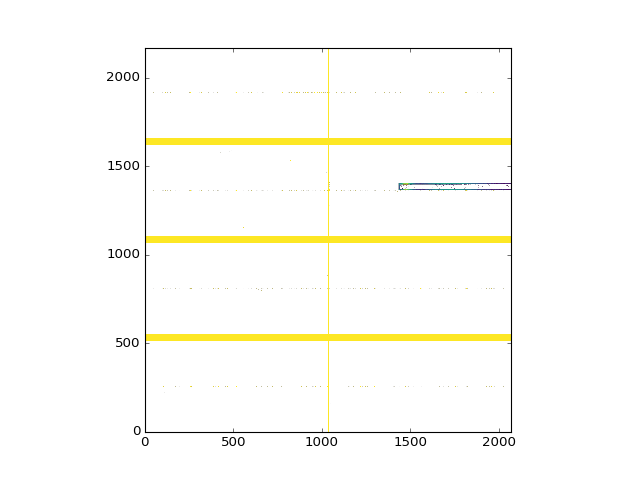

In [47]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.1, vmax= 1e2 ), cmap='viridis')
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


<IPython.core.display.Javascript object>


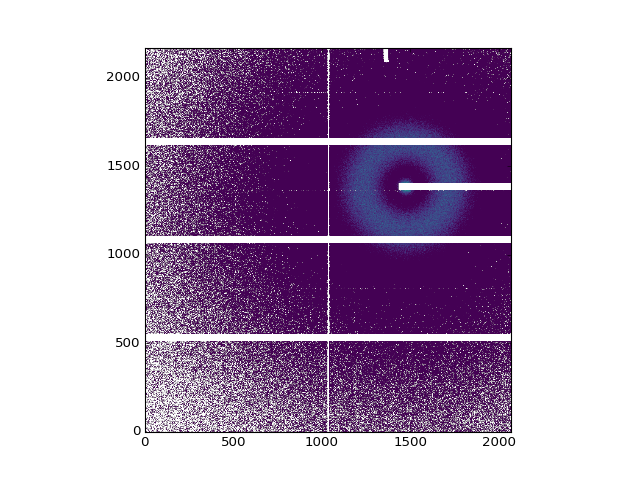

In [48]:
fig, ax = plt.subplots()
#new_mask = 
#im=ax.imshow(   (Mask) * avg_img,origin='lower' , 
#      norm= LogNorm( vmin=0.001, vmax=30 ), cmap='viridis')
#im = ax.imshow((mask)*avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
im = ax.imshow((mask)*avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=1, vmax=1000 ) )
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


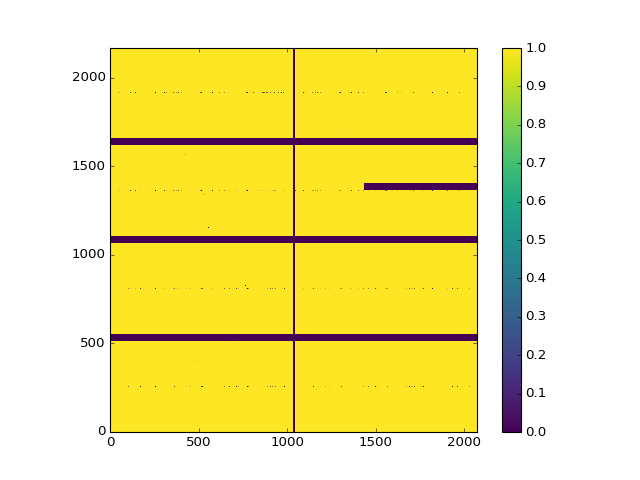

In [49]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Save the combined mask to use in further data analysis

In [50]:
np.save(  path +   uid +"_mask", mask)

In [245]:
#np.save(  path +   'July3' +"_mask", mask)

In [246]:
path +   uid +"_mask"

'/XF11ID/analysis/2016_3/masks/d378a0_mask'

In [52]:
#np.save(  path +   'Octo28_4M' +"_mask", mask)

In [51]:
path +   'Octo28_4M' +"_mask"

'/XF11ID/analysis/2016_3/masks/Octo28_4M_mask'

In [40]:
#np.save(  path +   'Octo21_1M_pixel' +"_mask", md['pixel_mask'])